In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
import keras
# from keras.applications.xception import Xception
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet121
import cv2
import os
import seaborn as sns
# from keras.preprocessing.image import load_img, img_to_array


import warnings
warnings.filterwarnings('ignore')

def display_image(image, title=''):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Using TensorFlow backend.


# load data

In [2]:
#vgg can't take input of 28x28 so we shall resize all our images
pickle_folder = "pickle files"
input_shape=(32, 32, 1)
data = pickle.load(open('data.pickle', 'rb'))
print("Data of format:")
for ch in data:
    print("data_length(" + ch + ") =", len(data[ch]))

#no. of classes
classes = len(data.keys())

Data of format:
data_length(द) = 2000
data_length(त्र) = 2000
data_length(ठ) = 2000
data_length(स) = 2000
data_length(छ) = 2000
data_length(ड) = 2000
data_length(ष) = 2000
data_length(थ) = 2000
data_length(क्ष) = 2000
data_length(च) = 2000
data_length(ह) = 2000
data_length(ध) = 2000
data_length(ङ) = 2000
data_length(न) = 2000
data_length(झ) = 2000
data_length(म) = 2000
data_length(ट) = 2000
data_length(ग) = 2000
data_length(ढ) = 2000
data_length(य) = 2000
data_length(ब) = 2000
data_length(ण) = 2000
data_length(ल) = 2000
data_length(ज्ञ) = 2000
data_length(र) = 2000
data_length(ञ) = 2000
data_length(श) = 2000
data_length(क) = 2000
data_length(घ) = 2000
data_length(त) = 2000
data_length(प) = 2000
data_length(भ) = 2000
data_length(ज) = 2000
data_length(फ) = 2000
data_length(ख) = 2000
data_length(व) = 2000


In [3]:
for ch in data:
    data[ch] = data[ch][0]
    data[ch] = cv2.resize(data[ch], (input_shape[0], input_shape[1])).reshape((input_shape[0], input_shape[1], 1))

# CNN

In [4]:
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


print("GPUs:", k.tensorflow_backend._get_available_gpus())

print("input shape:", input_shape)
print("classes:", classes)

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']
input shape: (32, 32, 1)
classes: 36


creating the model below

In [5]:
# path_to_model = "pickle files/36/Lenet_ब_य_ञ_त_क्ष_फ_ठ_स_छ_ज्ञ_च_ण_द_र_ट_म_प_क_ङ_भ_न_ल_ह_त्र_ज_ख_झ_थ_घ_श_ष_ग_व_ढ_ड_ध.h5"

path_to_model = "pickle files/2-5 permutations/Lenet_क_व.h5"
model = keras.models.load_model(os.path.join(path_to_model))

# Class Activations

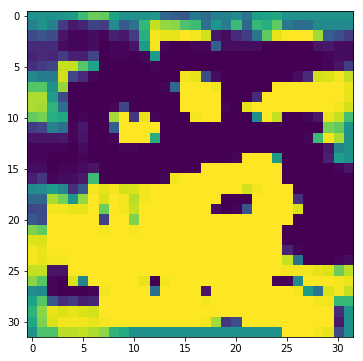

In [30]:
from vis.input_modifiers import Jitter
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

layer_idx = -1
ch = 'म'

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 20 is the imagenet category for 'ouzel'
#, backprop_modifier='relu', grad_modifier=None
#, input_modifiers=[Jitter(16)]
img = visualize_activation(model, -1, filter_indices=None, seed_input=data[ch], input_modifiers=[Jitter(16)])
plt.imshow(img.reshape(img.shape[:2]))

In [32]:
count = 0
for layer in model.layers:
    print(count, layer.name)
    count += 1

0 conv2d_19
1 max_pooling2d_13
2 dropout_19
3 conv2d_20
4 max_pooling2d_14
5 dropout_20
6 conv2d_21
7 flatten_7
8 dense_13
9 dropout_21
10 dense_14


In [106]:
img = (data['म']*255+0.001).astype(np.uint8)

print(img.max(), img.shape)

255 (32, 32, 1)


In [ ]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam, overlay

# penultimate_layer = utils.find_layer_idx(model, 'dense_14')
layer_idx = 10
penultimate_layer = 9

# for modifier in [None, 'guided', 'relu']:
#     plt.figure()
#     f, ax = plt.subplots(1, 2)
#     plt.suptitle("vanilla" if modifier is None else modifier)
#     for i, img in enumerate([data[ch], data[ch]]):    
        # 20 is the imagenet index corresponding to `ouzel`
grads = visualize_cam(model, layer_idx, filter_indices=20, 
                      seed_input=img, penultimate_layer_idx=7, 
                      backprop_modifier='relu')  

jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
f, ax = plt.subplots(3, 1)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
ax[1].imshow(jet_heatmap)
ax[2].imshow(overlay(jet_heatmap, cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)))
# plt.show()

        # Lets overlay the heatmap onto original image.    
#         jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
#         ax[i].imshow(overlay(jet_heatmap, img))

In [118]:
grads.min()

0.0

In [114]:
np.unique(jet_heatmap[:, :, 2], return_counts=True)

(array([127], dtype=uint8), array([1024]))

# visualizations (layers)

0 (32, 32)


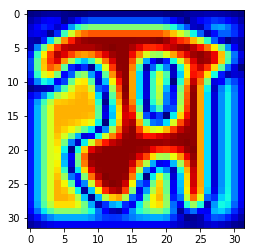

In [6]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import time

# Swap softmax with linear
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

# character
ch = 'म'

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
for layer in model.layers:
    if layer.name.split('_')[0] != 'dropout':
        layer_idx = utils.find_layer_idx(model, layer.name)
        
        grads = visualize_saliency(model, layer_idx, filter_indices=None, 
                                   seed_input=data[ch], backprop_modifier='guided')
        print(layer_idx, grads.shape)
        plt.imshow(grads, cmap='jet')
        plt.show()
        break
#         for i, modifier in enumerate([None, 'guided', 'relu']):
#             grads = visualize_saliency(model, layer_idx, filter_indices=count, 
#                                        seed_input=data[ch], backprop_modifier=modifier)
#             if modifier is None:
#                 modifier = 'vanilla'
#             ax[i+1].set_title(modifier)    
#             ax[i+1].imshow(grads, cmap='jet')
#         ax[4].set_title("negate")
#         ax[4].imshow(visualize_saliency(model, layer_idx, filter_indices=count, seed_input=data[ch], 
#                                backprop_modifier='guided', grad_modifier='negate'))
#         count += 1
#         print("Took {} seconds to complete for {}".format(time.time() - start, ch))

# visualizations (characters)

In [6]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'pred')
layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

In [ ]:
import time

count = 0
for ch in data:
    start = time.time()
    f, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax[0].imshow(data[ch].reshape(*input_shape[:2]))
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=count, 
                                   seed_input=data[ch], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')
    ax[4].set_title("negate")
    ax[4].imshow(visualize_saliency(model, layer_idx, filter_indices=count, seed_input=data[ch], 
                           backprop_modifier='guided', grad_modifier='negate'))
    count += 1
    print("Took {} seconds to complete for {}".format(time.time() - start, ch))